#<b>Milestone 2

###<b> Mounting the Drive

In [3]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###<b>Loading libraries</b>

In [4]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [5]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/CNN Malaria Detection/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

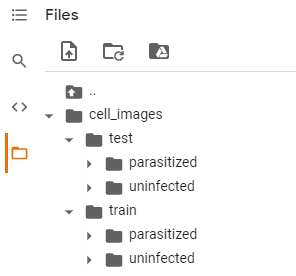

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [6]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [7]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (224,224)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [9]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (128,128)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b>Normalize the images

In [10]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255).astype('float32')
test_images = (test_images/225).astype('float32')

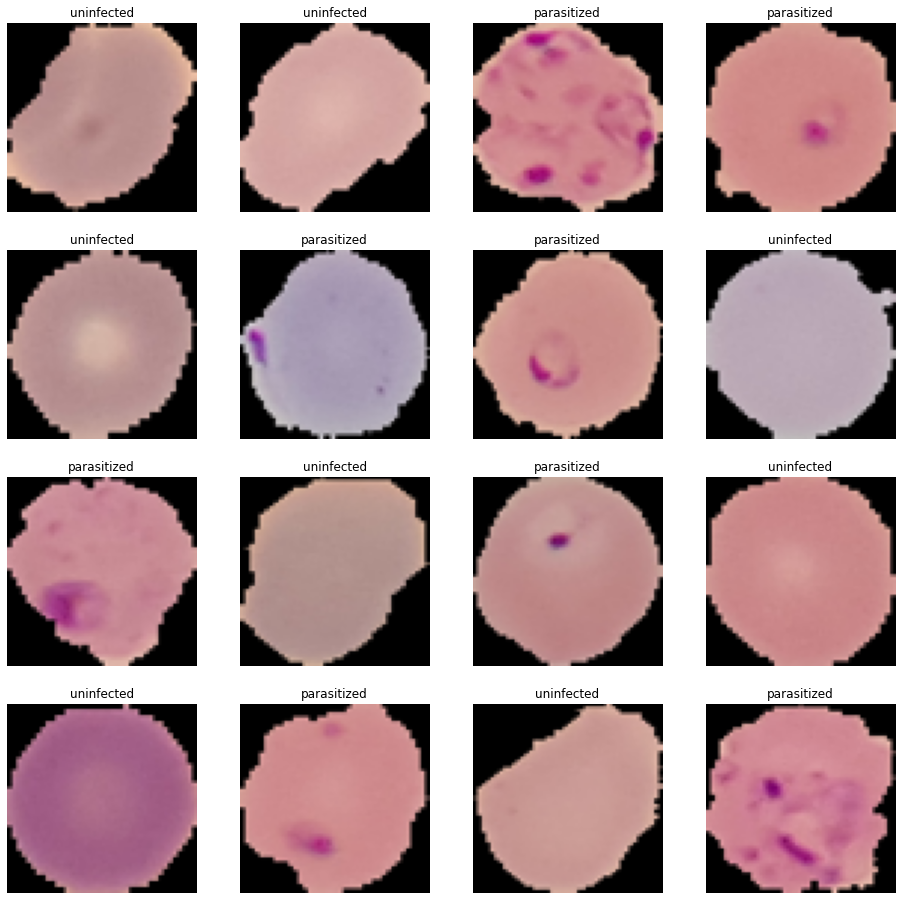

In [11]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

###<B>One Hot Encoding on the train and test labels

In [12]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

[1.0.] is uninfected, [0.1.] is paracitized


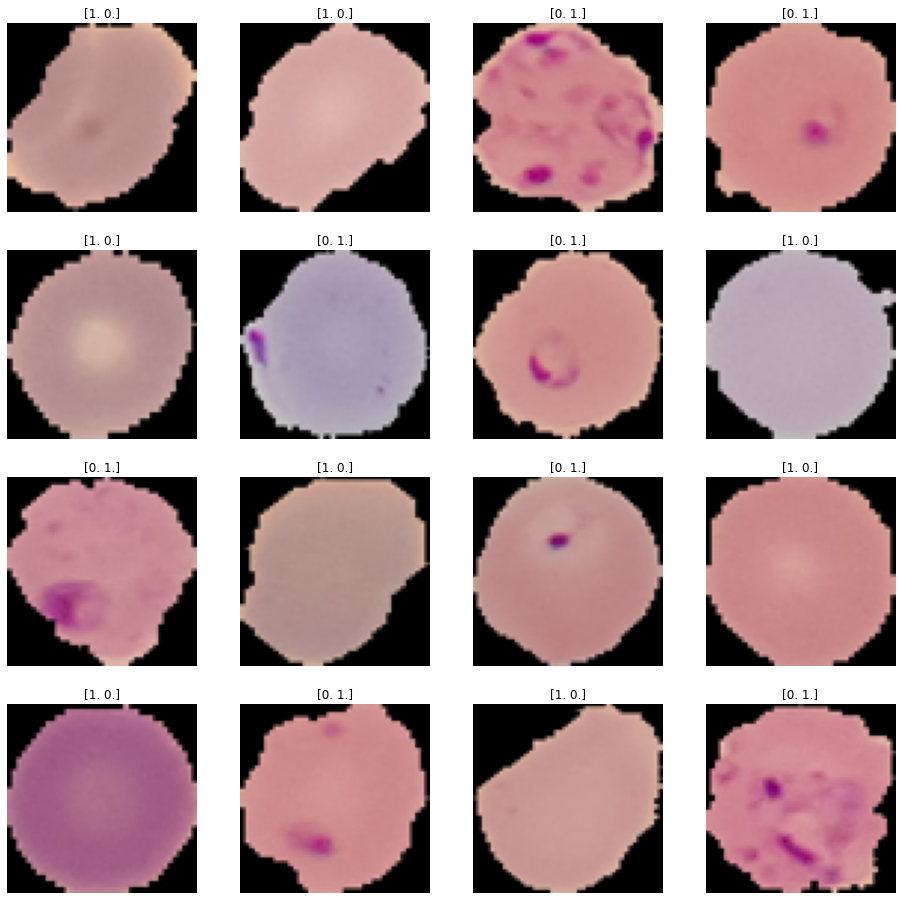

In [13]:
# This code will help you in visualizing both the parasitized and uninfected images
print('[1.0.] is uninfected, [0.1.] is paracitized')

np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    plt.title(train_labels[index] )
    plt.imshow(train_images[index])
    plt.axis('off')

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [23]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [24]:

#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [26]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [27]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 105s 166ms/step - loss: 0.4326 - accuracy: 0.7905 - val_loss: 0.2500 - val_accuracy: 0.9271
Epoch 2/20
624/624 [==============================] - 98s 157ms/step - loss: 0.1785 - accuracy: 0.9384 - val_loss: 0.1911 - val_accuracy: 0.9573
Epoch 3/20
624/624 [==============================] - 98s 157ms/step - loss: 0.1610 - accuracy: 0.9454 - val_loss: 0.1764 - val_accuracy: 0.9688
Epoch 4/20
624/624 [==============================] - 97s 156ms/step - loss: 0.1484 - accuracy: 0.9525 - val_loss: 0.2143 - val_accuracy: 0.9511
Epoch 5/20
624/624 [==============================] - 97s 156ms/step - loss: 0.1451 - accuracy: 0.9528 - val_loss: 0.1797 - val_accuracy: 0.9599


####<b> Evaluating the model on test data

In [28]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 39ms/step - loss: 0.1561 - accuracy: 0.9523

 Test_Accuracy:- 0.9523077011108398


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1300
           1       0.96      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



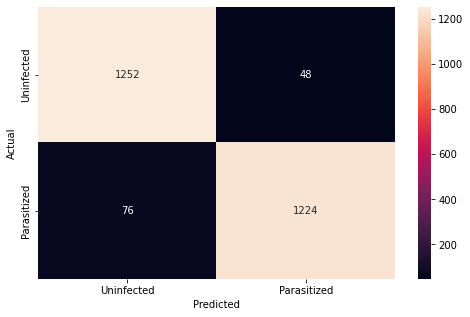

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [30]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

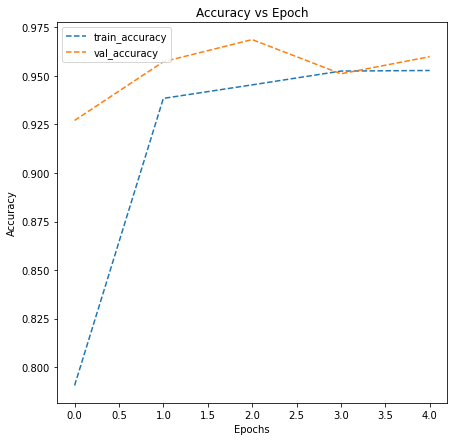

In [31]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [42]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [43]:
#creating sequential model
model1=Sequential()



# Build the model here

model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

# New things 

model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(LeakyReLU(0.1))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(BatchNormalization())

model1.add(Flatten())

model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [44]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [45]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [46]:
history1=model1.fit(train_images,train_labels,batch_size=64,callbacks=callbacks,  validation_split=.02,epochs=20,verbose=1)
# first epoch set to 20

Epoch 1/20
383/383 [==============================] - 105s 271ms/step - loss: 0.6022 - accuracy: 0.6674 - val_loss: 0.8266 - val_accuracy: 0.8060
Epoch 2/20
383/383 [==============================] - 102s 266ms/step - loss: 0.1799 - accuracy: 0.9436 - val_loss: 0.1342 - val_accuracy: 0.9640
Epoch 3/20
383/383 [==============================] - 101s 264ms/step - loss: 0.1612 - accuracy: 0.9507 - val_loss: 0.1099 - val_accuracy: 0.9680
Epoch 4/20
383/383 [==============================] - 101s 263ms/step - loss: 0.1550 - accuracy: 0.9522 - val_loss: 0.1047 - val_accuracy: 0.9640
Epoch 5/20
383/383 [==============================] - 101s 263ms/step - loss: 0.1453 - accuracy: 0.9545 - val_loss: 0.1099 - val_accuracy: 0.9620
Epoch 6/20
383/383 [==============================] - 97s 253ms/step - loss: 0.1470 - accuracy: 0.9547 - val_loss: 0.1704 - val_accuracy: 0.9500


####<b> Evaluating the model

In [47]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])


82/82 [==============================] - 3s 35ms/step - loss: 0.1574 - accuracy: 0.9512

 Test_Accuracy:- 0.9511538743972778


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1300
           1       0.96      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



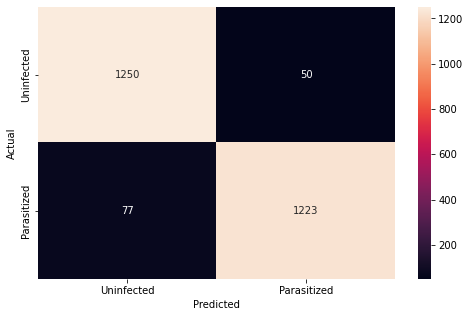

In [48]:
pred = model1.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

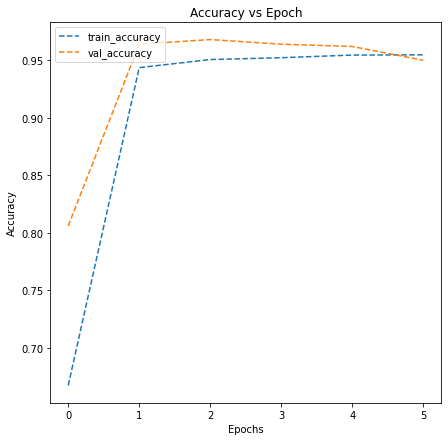

In [49]:
plot_accuracy(history1)

####<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Images converted to HSV

In [28]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [37]:
# Convert train images to HSV

import cv2
HSV_train=[]   # to hold the HSV image array
for i in np.arange(0,24958,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  HSV_train.append(a)
HSV_train=np.array(HSV_train)



In [38]:
# Convert test images to HSV

import cv2
HSV_test=[]   # to hold the HSV image array
for i in np.arange(0,2600,1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
  HSV_test.append(a)
HSV_test=np.array(HSV_test)


In [39]:
#Building a model for HSV data
modelHSV=Sequential()

# Build the model here

modelHSV.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
modelHSV.add(MaxPooling2D(pool_size=2))
modelHSV.add(Dropout(0.2))
modelHSV.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
modelHSV.add(MaxPooling2D(pool_size=2))
modelHSV.add(Dropout(0.2))
modelHSV.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
modelHSV.add(MaxPooling2D(pool_size=2))
modelHSV.add(Dropout(0.2))
modelHSV.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
modelHSV.add(MaxPooling2D(pool_size=2))
modelHSV.add(LeakyReLU(0.1))
modelHSV.add(MaxPooling2D(pool_size=2))
modelHSV.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
modelHSV.add(MaxPooling2D(pool_size=2))
modelHSV.add(BatchNormalization())

modelHSV.add(Flatten())

modelHSV.add(Dense(512,activation="relu"))
modelHSV.add(Dropout(0.4))
modelHSV.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 


adam = optimizers.Adam(learning_rate=0.001)

modelHSV.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)       

####<b>Compiling the model

In [40]:
modelHSV.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> Using callbacks

In [41]:

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]


<b>Fit and train the model

In [42]:
historyHSV = modelHSV.fit (HSV_train,train_labels,batch_size=64,validation_split=0.1,epochs=20,verbose=1)

Epoch 1/20
351/351 [==============================] - 91s 256ms/step - loss: 0.6827 - accuracy: 0.5787 - val_loss: 0.3450 - val_accuracy: 0.9780
Epoch 2/20
351/351 [==============================] - 89s 254ms/step - loss: 0.6627 - accuracy: 0.6108 - val_loss: 0.0936 - val_accuracy: 0.9988
Epoch 3/20
351/351 [==============================] - 89s 254ms/step - loss: 0.6442 - accuracy: 0.6356 - val_loss: 0.0517 - val_accuracy: 0.9976
Epoch 4/20
351/351 [==============================] - 89s 252ms/step - loss: 0.6367 - accuracy: 0.6419 - val_loss: 0.1246 - val_accuracy: 0.9627
Epoch 5/20
351/351 [==============================] - 91s 258ms/step - loss: 0.6256 - accuracy: 0.6537 - val_loss: 0.0365 - val_accuracy: 0.9920
Epoch 6/20
351/351 [==============================] - 87s 249ms/step - loss: 0.6161 - accuracy: 0.6626 - val_loss: 0.0247 - val_accuracy: 0.9952
Epoch 7/20
351/351 [==============================] - 88s 250ms/step - loss: 0.5984 - accuracy: 0.6799 - val_loss: 0.0360 - val_ac

<b>Plotting the train and validation accuracy

In [8]:
# plotting the accuracies
plot_accuracy(historyHSV)

NameError: ignored

####<b>Evaluating the model

In [36]:
# Evaluate the model to calculate the accuracy
accuracyHSV = modelHSV.evaluate(HSV_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 33ms/step - loss: 0.1660 - accuracy: 0.9442

 Test_Accuracy:- 0.948846161365509


#####**Observations and insights:**

The validation accuracy stayed high thoughout the epochs, since both the training a nd test data has a 50/50 split, this may be due to a smaller test data set. 

I will continue to try each iteration of models with both regular and HSV images. 

<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1300
           1       0.98      0.91      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.95      0.94      0.94      2600
weighted avg       0.95      0.94      0.94      2600



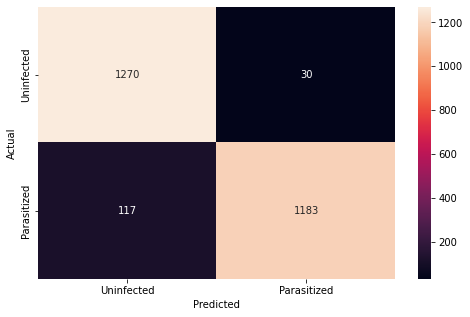

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = modelHSV.predict(HSV_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

The current models return high accuracy ~95% and high recall ~98%, but we need to reach 99% for medical use. Training on images that have been augmented may help the model to recognize what is different between the uninfected and paracitized. 



###<b>Model 3 with Data Augmentation

In [66]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, train_size=0.8, random_state=42) #changed from train_size=0.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)

####**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

[1.0.] is uninfected, [0.1.] is paracitized


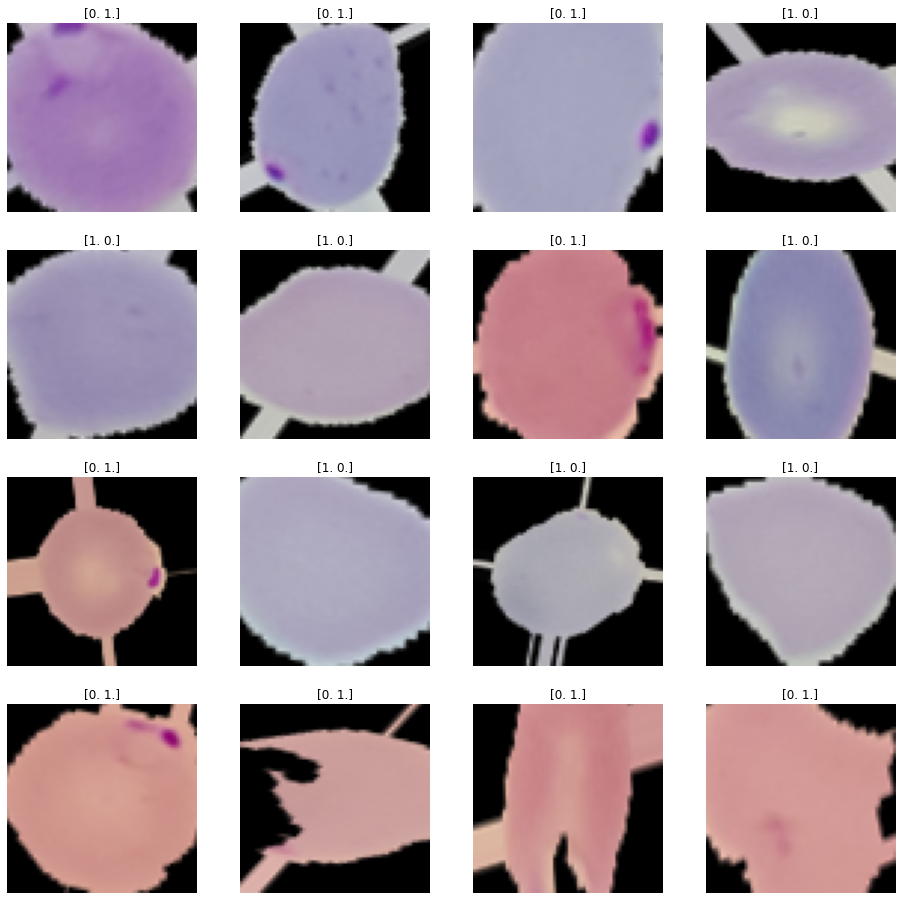

In [68]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

print('[1.0.] is uninfected, [0.1.] is paracitized')

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title(label)
    #if label == : 
       # ax.set_title('parasitized')
    #else:
       # ax.set_title('uninfected')
    ax.axis('off')

#####**Observations and insights:**

I'm worried that some of the infected images where the parasite is not visable willconfuse the system, but lets see. 

####<b>Building the Model

In [16]:
model3 = Sequential()

# Build the model here
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(512,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 

# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

<b>Using Callbacks

In [70]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [71]:
history3 = model3.fit(train_generator, validation_data=val_generator, batch_size=64,callbacks=callbacks,epochs=20,verbose=1)


Epoch 1/20
312/312 [==============================] - 94s 299ms/step - loss: 0.6516 - accuracy: 0.6194 - val_loss: 0.7741 - val_accuracy: 0.5066
Epoch 2/20
312/312 [==============================] - 92s 294ms/step - loss: 0.4076 - accuracy: 0.8145 - val_loss: 0.2335 - val_accuracy: 0.9445
Epoch 3/20
312/312 [==============================] - 91s 292ms/step - loss: 0.2503 - accuracy: 0.9122 - val_loss: 0.1666 - val_accuracy: 0.9545
Epoch 4/20
312/312 [==============================] - 91s 291ms/step - loss: 0.2377 - accuracy: 0.9203 - val_loss: 0.1647 - val_accuracy: 0.9537
Epoch 5/20
312/312 [==============================] - 91s 291ms/step - loss: 0.2240 - accuracy: 0.9250 - val_loss: 0.1546 - val_accuracy: 0.9561
Epoch 6/20
312/312 [==============================] - 91s 292ms/step - loss: 0.2208 - accuracy: 0.9259 - val_loss: 0.1593 - val_accuracy: 0.9521
Epoch 7/20
312/312 [==============================] - 91s 291ms/step - loss: 0.2165 - accuracy: 0.9266 - val_loss: 0.1610 - val_ac

####<B>Evaluating the model

<b>Plot the train and validation accuracy

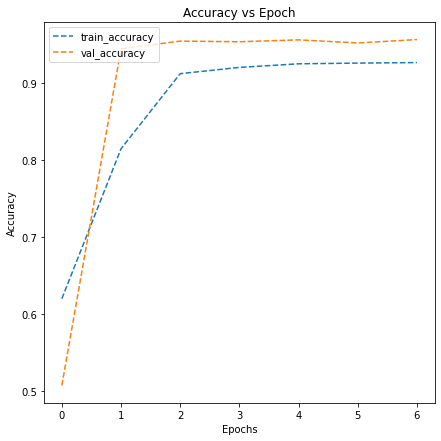

In [72]:
# plotting the accuracies
plot_accuracy(history3)



In [41]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels)
print('\n', 'Test_Accuracy:-', accuracy3[1])

TypeError: ignored

**Observations**

- computer crashed several times attempting to complete this model. 
- model accuracy is low, and not imporving. 
- Data Augmentation with ImageDataGenerator does not improve the model. 

<B>Plotting the classification report and confusion matrix

In [ ]:
pred = model3.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(val_generator,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [21]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))    #top = Falso when shape is smaller
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [35]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
# Add a dense layer with 64 neurons
x = Dense(64, activation='relu')(x)


x = BatchNormalization()(x)
pred = Dense(2, activation='softmax')(x)

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [36]:
model4.compile(loss="binary_crossentropy", metrics = ['accuracy'])
model4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

<b> using callbacks

In [41]:
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

<b>Fit and Train the model

In [45]:
#Fitting the model and running the model for 10 epochs  
# if model repeats 10 epochs, train with 20 exct. 
history4 = model4.fit(train_images,train_labels, epochs=10, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)
 


Epoch 1/10
312/312 [==============================] - 1001s 3s/step - loss: 0.1596 - accuracy: 0.9396 - val_loss: 0.1868 - val_accuracy: 0.9253
Epoch 2/10
312/312 [==============================] - 1001s 3s/step - loss: 0.1580 - accuracy: 0.9409 - val_loss: 0.4458 - val_accuracy: 0.8189
Epoch 3/10
312/312 [==============================] - 1001s 3s/step - loss: 0.1546 - accuracy: 0.9415 - val_loss: 0.2159 - val_accuracy: 0.9225


<b>Plot the train and validation accuracy

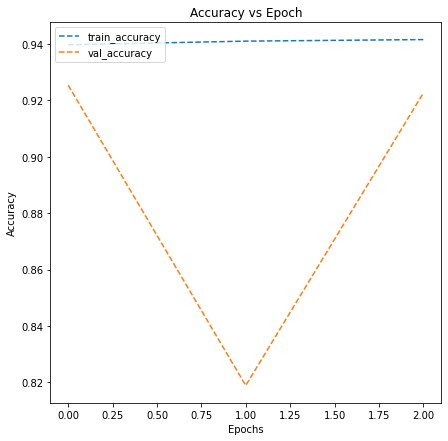

In [73]:
# plotting the accuracies
plot_accuracy(history4)

#####**Observations and insights: **

- accuracy is still below 99% 
- Model is overfitting

####<b> Evaluating the model

In [49]:
# Evaluating the model on test data
accuracy4 = model4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 106s 1s/step - loss: 0.1838 - accuracy: 0.9331

 Test_Accuracy:- 0.949999988079071


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1300
           1       0.91      0.96      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



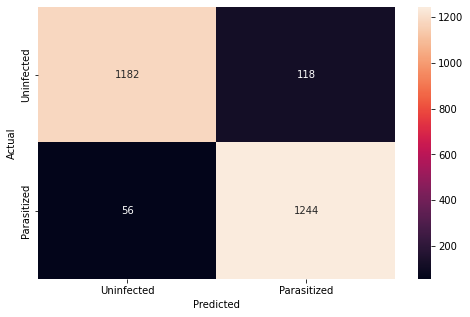

In [50]:
# Plot the confusion matrix and generate a classification report for the model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choosw the model with the best accuracy scores from all the above models and save it as a final model.


###**Observations and Conclusions drawn from model 4:**

- Model is still below 99%
- Model4 is running incredably slowly, 999s per epoch
- Suggestions for improving the accuracy
    - Increase model depth
    - Test new models using HSV and Unchanged Images 
    




###<b> Model 5 - A Deeper Model

In [16]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

#### Building The Model

In [17]:
#creating sequential model
model5=Sequential()

# Original Model 

model5.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))            
model5.add(MaxPooling2D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Dropout(0.2))

#Increasing the number of filters to increase complexity

model5.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))

model5.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(Dropout(0.2)) #Dropout to reduce overfitting

model5.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(Dropout(0.2))

model5.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(LeakyReLU(0.1))


model5.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model5.add(MaxPooling2D(pool_size=2,padding='same'))
model5.add(BatchNormalization())

model5.add(Flatten())

model5.add(Dense(4096,activation="relu"))
model5.add(Dropout(0.4))
model5.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

#### Compile, Fit and Train the model 

In [70]:
# Compile the model
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [72]:
#Fit and train the model
history5 = model5.fit(train_images,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)

Epoch 1/20
312/312 [==============================] - 297s 947ms/step - loss: 0.4887 - accuracy: 0.7462 - val_loss: 1.3857 - val_accuracy: 0.0000e+00
Epoch 2/20
312/312 [==============================] - 292s 937ms/step - loss: 0.1589 - accuracy: 0.9493 - val_loss: 0.1760 - val_accuracy: 0.9651
Epoch 3/20
312/312 [==============================] - 289s 928ms/step - loss: 0.1483 - accuracy: 0.9524 - val_loss: 0.1780 - val_accuracy: 0.9629
Epoch 4/20
312/312 [==============================] - 289s 927ms/step - loss: 0.1431 - accuracy: 0.9534 - val_loss: 0.1511 - val_accuracy: 0.9627
Epoch 5/20
312/312 [==============================] - 289s 925ms/step - loss: 0.1402 - accuracy: 0.9550 - val_loss: 0.1328 - val_accuracy: 0.9746
Epoch 6/20
312/312 [==============================] - 289s 926ms/step - loss: 0.1347 - accuracy: 0.9560 - val_loss: 0.1839 - val_accuracy: 0.9605
Epoch 7/20
312/312 [==============================] - 289s 926ms/step - loss: 0.1350 - accuracy: 0.9548 - val_loss: 0.16

#### Evaluate the Model

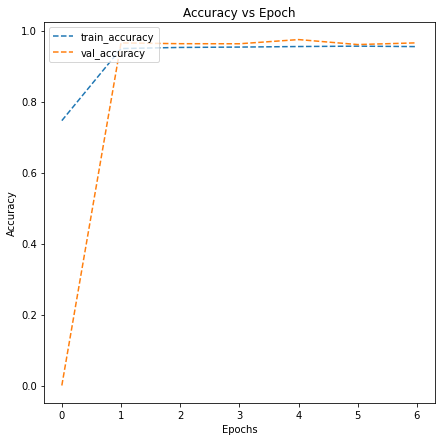

In [74]:
plot_accuracy(history5)

In [75]:
# Evaluating the model on test data
accuracy5 = model5.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])



82/82 [==============================] - 8s 96ms/step - loss: 0.1534 - accuracy: 0.9512

 Test_Accuracy:- 0.949999988079071


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1300
           1       0.96      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



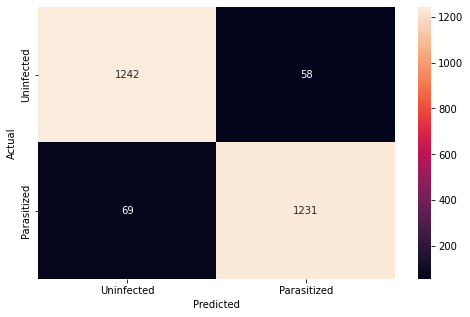

In [76]:
# Plot the confusion matrix and generate a classification report for the model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model5.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Insights

-  HSV has not shown to increast accuracy in amodel, thought he false negative decrease. 
- the CNN will need to be deeper or apply different techniques
- Techniques to continue trying
    - more batch normalization
    - weight decay (model iis not overfitting so I don't believe this will help) 

### Model 5 with HSV

####Converting to HSV 

In [14]:
# Convert train images to HSV

import cv2
HSV_train=[]   # to hold the HSV image array
for i in np.arange(0,24958,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  HSV_train.append(a)
HSV_train=np.array(HSV_train)


# Convert test images to HSV

import cv2
HSV_test=[]   # to hold the HSV image array
for i in np.arange(0,2600,1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
  HSV_test.append(a)
HSV_test=np.array(HSV_test)

Compile and Train model 5 with HSV

In [18]:
# Compile the model       not sure if I need this, try without first
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [20]:
#Fit and train the model
history5_HSV = model5.fit(HSV_train,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)

Epoch 1/20
312/312 [==============================] - 277s 883ms/step - loss: 0.6696 - accuracy: 0.6151 - val_loss: 0.8401 - val_accuracy: 0.0000e+00
Epoch 2/20
312/312 [==============================] - 274s 878ms/step - loss: 0.6602 - accuracy: 0.6254 - val_loss: 0.7830 - val_accuracy: 0.0443
Epoch 3/20
312/312 [==============================] - 271s 870ms/step - loss: 0.6422 - accuracy: 0.6525 - val_loss: 0.6367 - val_accuracy: 0.7181
Epoch 4/20
312/312 [==============================] - 271s 868ms/step - loss: 0.6325 - accuracy: 0.6620 - val_loss: 0.5641 - val_accuracy: 0.7418
Epoch 5/20
312/312 [==============================] - 270s 864ms/step - loss: 0.6287 - accuracy: 0.6614 - val_loss: 0.8304 - val_accuracy: 0.3045
Epoch 6/20
312/312 [==============================] - 269s 862ms/step - loss: 0.6182 - accuracy: 0.6697 - val_loss: 0.5105 - val_accuracy: 0.7410
Epoch 7/20
312/312 [==============================] - 266s 853ms/step - loss: 0.3941 - accuracy: 0.8269 - val_loss: 0.15

####Evaluate the model

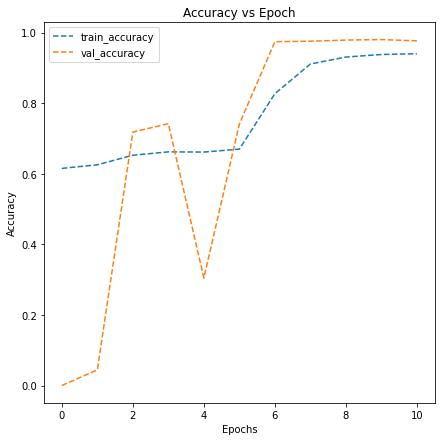

In [23]:
plot_accuracy(history5_HSV)

In [25]:
# Evaluating the model on test data
accuracy5_HSV = model5.evaluate(HSV_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy5_HSV[1])

82/82 [==============================] - 7s 88ms/step - loss: 0.1665 - accuracy: 0.9488

 Test_Accuracy:- 0.948846161365509


              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1300
           1       0.98      0.92      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



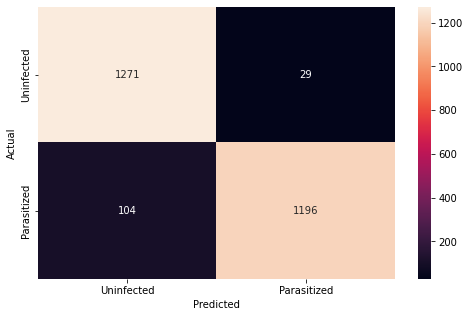

In [26]:
# Plot the confusion matrix and generate a classification report for the model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model5.predict(HSV_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###Model 6 - increased batch normalization 

In [50]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

#### Building the Model

In [53]:
#creating sequential model
model6=Sequential()

# Model 5 with batchnormalization applied to every layer instead of dropout

model6.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="LeakyReLU",input_shape=(64,64,3)))
model6.add(MaxPooling2D(pool_size=2))
#model6.add(BatchNormalization())
#model6.add(Dropout(0.2))

model6.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="LeakyReLU"))            
model6.add(MaxPooling2D(pool_size=2))
#model6.add(BatchNormalization())
#model6.add(Dropout(0.2))

model6.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="LeakyReLU"))
model6.add(MaxPooling2D(pool_size=2))
#model6.add(BatchNormalization())
#model6.add(Dropout(0.2))

model6.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="LeakyReLU"))
model6.add(MaxPooling2D(pool_size=2,padding='same'))

model6.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="LeakyReLU"))
model6.add(MaxPooling2D(pool_size=2,padding='same'))
#model6.add(BatchNormalization())
#model6.add(Dropout(0.2)) #Dropout to reduce overfitting

model6.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="LeakyReLU"))
model6.add(MaxPooling2D(pool_size=2,padding='same'))
#model6.add(Dropout(0.2))

model6.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="LeakyReLU"))
model6.add(MaxPooling2D(pool_size=2,padding='same'))
model6.add(LeakyReLU(0.1))
model6.add(BatchNormalization())

model6.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="LeakyReLU"))
model6.add(MaxPooling2D(pool_size=2,padding='same'))
model6.add(BatchNormalization())

#model6.add(Dropout(0.2)) #Dropout to reduce overfitting


model6.add(Flatten())

model6.add(Dense(4096,activation="relu"))
model6.add(Dropout(0.4))
model6.add(Dense(2,activation="sigmoid"))#2 represent output layer neurons 
model6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 128)       1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)        

#### Compile, fit and train the data

In [54]:
# Compile the model
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
#Call Backs 
callbacks = EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)

In [56]:
#Fit and train the model
history6 = model6.fit(train_images,train_labels, epochs=20, callbacks= callbacks, batch_size= 64, validation_split=0.2, verbose=1)

Epoch 1/20
312/312 [==============================] - 334s 1s/step - loss: 0.2539 - accuracy: 0.8915 - val_loss: 1.2970 - val_accuracy: 0.0106
Epoch 2/20
312/312 [==============================] - 386s 1s/step - loss: 0.1402 - accuracy: 0.9545 - val_loss: 0.7991 - val_accuracy: 0.6218
Epoch 3/20
312/312 [==============================] - 374s 1s/step - loss: 0.1320 - accuracy: 0.9557 - val_loss: 0.0766 - val_accuracy: 0.9794
Epoch 4/20
312/312 [==============================] - 332s 1s/step - loss: 0.1284 - accuracy: 0.9580 - val_loss: 0.0272 - val_accuracy: 0.9918
Epoch 5/20
312/312 [==============================] - 338s 1s/step - loss: 0.1174 - accuracy: 0.9606 - val_loss: 2.3470 - val_accuracy: 0.0000e+00
Epoch 6/20
312/312 [==============================] - 332s 1s/step - loss: 0.1179 - accuracy: 0.9603 - val_loss: 0.1629 - val_accuracy: 0.9645


#### Evaluate the model

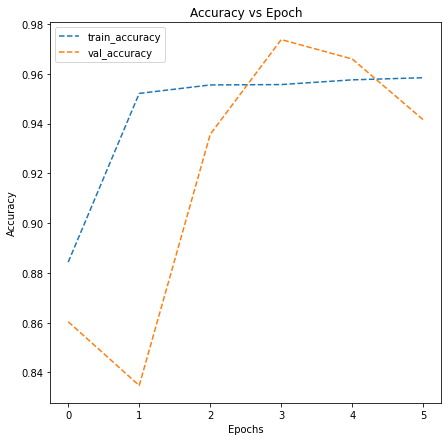

In [64]:
plot_accuracy(history6)

In [65]:
# Evaluating the model on test data
accuracy6 = model6.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy6[1])

82/82 [==============================] - 7s 87ms/step - loss: 0.2174 - accuracy: 0.9396

 Test_Accuracy:- 0.9396153688430786


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1300
           1       0.96      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



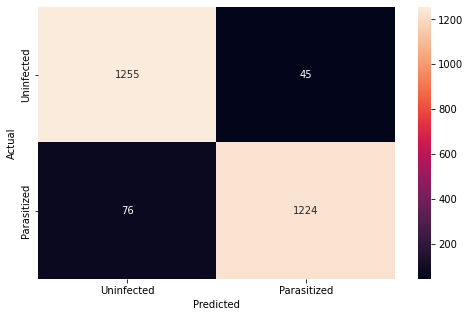

In [56]:
# Plot the confusion matrix and generate a classification report for the model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model6.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Insights

- model is not overfitting, so taking some batch normalization out my help
- First try 
    - included match normalization after EVERY layer. 
    - loss: 0.1682 - accuracy: 0.9469 - Test_Accuracy:- 0.9469230771064758
    - --------------precision ------ recall-------f1-score --------  support

           0       0.94      0.96      0.95      1300
           1       0.96      0.94      0.95      1300

    - accuracy----------------------------------------------0.95----------2600
    - macro avg-----0.95 --------- 0.95 -------------0.95----------2600
    - weighted avg-0.95----------0.95--------------0.95-----------2600
- 2nd Itterateion 
    - Batch Normalization after EVERY OTHER layer
    - loss: 0.1807 - accuracy: 0.9492 - Test_Accuracy:- 0.9492307901382446
- 3rd Ιtteration
    - Βatch Normalization only at the end
    - loss: 0.1638 - accuracy: 0.9535 - Test_Accuracy:- 0.9534615278244019
- 4th itteration 
    - No Batch Normalization 
    - loss: 0.2174 - accuracy: 0.9396 - Test_Accuracy:- 0.9396153688430786
- 5th itteration
    - only using LeakyRelu activation and Βatch Normalization at the end


### Model 7 - 

###<b>Insights